In [21]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Jury Selection ###
In 2010, the ACLU presented a report on jury selection in Alameda County, California. The report concluded that certain ethnic groups are underrepresented among jury panelists in Alameda County, and suggested some reforms of the process by which eligible jurors are assigned to panels. In this section, we will perform our own analysis of the data and examine some questions that arise as a result.

### Jury Panels ###

A jury panel is a group of people chosen to be prospective jurors; the final trial jury is selected from among them. Jury panels can consist of a few dozen people or several thousand, depending on the trial. By law, a jury panel is supposed to be representative of the community in which the trial is taking place. Section 197 of California's Code of Civil Procedure says, "All persons selected for jury service shall be selected at random, from a source or sources inclusive of a representative cross section of the population of the area served by the court."

The final jury is selected from the panel by deliberate inclusion or exclusion. The law allows potential jurors to be excused for medical reasons; lawyers on both sides may strike a certain number of potential jurors from the list in what are called "peremptory challenges"; the trial judge might make a selection based on questionnaires filled out by the panel; and so on. But the initial panel is supposed to resemble a random sample of the population of eligible jurors.

### Composition of Panels in Alameda County ###

The focus of the study by the ACLU of Northern California was the ethnic composition of jury panels in Alameda County. The ACLU compiled data on the ethnic composition of the jury panels in 11 felony trials in Alameda County in the years 2009 and 2010. In those panels, the total number of poeple who reported for jury service was 1453. The ACLU gathered demographic data on all of these prosepctive jurors, and compared those data with the composition of all eligible jurors in the county. 

The data are tabulated below in a table called ``jury``. For each ethnicity, the first value is the proportion of all eligible juror candidates of that ethnicity. The second value is the proportion of people of that ethnicity among those who appeared for the process of selection into the jury.

In [6]:
jury = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

jury

Ethnicity,Eligible,Panels
Asian,0.15,0.26
Black,0.18,0.08
Latino,0.12,0.08
White,0.54,0.54
Other,0.01,0.04


Some ethnicities are overrepresented and some are underrepresented on the jury panels in the study. A bar chart is helpful for visualizing the differences.

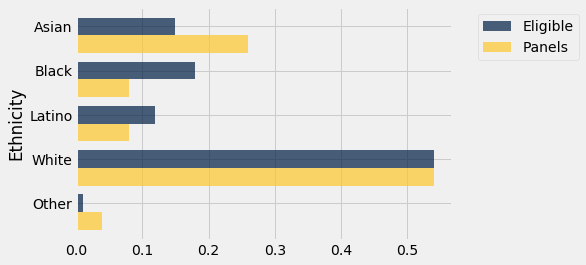

In [7]:
jury.barh('Ethnicity')

### Distance between Two Distributions ###
Visualizations give us a quick sense of the similarities and differences between two distributions. To say something more precise about those differences, we must first quantify the difference between two distributions. This will allow our analyses to be based on more than the assessements that we are able to make by eye.

To measure the difference between the two distributions, we will compute a quantity called the *total variation distance* between them. 

To compute the total variation distance, we first take the difference between the two proportions in each category.

In [8]:
# Augment the table with a column of differences between proportions

jury_with_diffs = jury.with_column(
    'Difference', jury.column('Panels') - jury.column('Eligible')
)
jury_with_diffs

Ethnicity,Eligible,Panels,Difference
Asian,0.15,0.26,0.11
Black,0.18,0.08,-0.1
Latino,0.12,0.08,-0.04
White,0.54,0.54,0
Other,0.01,0.04,0.03


Take a look at the column `Difference` and notice that the sum of its entries is 0: the positive entries add up to 0.14, exactly canceling the total of the negative entries which is -0.14. 

This is numerical evidence of the fact that in the bar chart, the gold bars exceed the blue bars by exactly as much as the blue bars exceed the gold. The proportions in each of the two columns ``Panels`` and ``Eligible`` add up to 1, and so the give-and-take between their entries must add up to 0. 

To avoid the cancellation, we drop the negative signs and then add all the entries. But this gives us two times the total of the positive entries (equivalently, two times the total of the negative entries, with the sign removed). So we divide the sum by 2.

In [9]:
jury_with_diffs = jury_with_diffs.with_column(
    'Abs. Difference', np.abs(jury_with_diffs.column('Difference'))
)

jury_with_diffs

Ethnicity,Eligible,Panels,Difference,Abs. Difference
Asian,0.15,0.26,0.11,0.11
Black,0.18,0.08,-0.1,0.1
Latino,0.12,0.08,-0.04,0.04
White,0.54,0.54,0,0
Other,0.01,0.04,0.03,0.03


In [10]:
jury_with_diffs.column('Abs. Difference').sum()/2

0.14000000000000001

This quantity 0.14 is the *total variation distance* (TVD) between the distribution of ethnicities in the eligible juror population and the distribution in the panels.

We could have obtained the same result by just adding the positive differences. But our method of including all the absolute differences eliminates the need to keep track of which differences are positive and which are not.

### Functions for Computing Total Variation Distance ###
The function `total_variation_distance` returns the TVD between distributions in two arrays.

In [11]:
def total_variation_distance(distribution_1, distribution_2):
    return np.abs(distribution_1 - distribution_2).sum()/2

The function `table_tvd` uses the function `total_variation_distance` to return the TVD between distributions in two columns of a table.

In [12]:
def table_tvd(table, label, other):
    return total_variation_distance(table.column(label), table.column(other))

table_tvd(jury, 'Eligible', 'Panels')

0.14000000000000001

### Are the panels representative of the population? ###

We will now turn to the numerical value of the total variation distance between the eligible jurors and the panels. How can we interpret the distance of 0.14? To answer this, recall that the panels are supposed to be selected at random. It will therefore be informative to compare the value of 0.14 with the total variation distance between the eligible jurors and a randomly selected panel.

To do this, we will employ our skills at simulation. There were 1453 prosepective jurors in the panels in the study. So let us take a random sample of size 1453 from the population of eligible jurors.

**Technical note.** Random samples of prospective jurors would be selected without replacement. However, when the size of a sample is small relative to the size of the population, sampling without replacement resembles sampling with replacement; the proportions in the population don't change much between draws. The population of eligible jurors in Alameda County is over a million, and compared to that, a sample size of about 1500 is quite small. We will therefore sample with replacement.

### Sampling at Random from the Eligible Population ###

Thus far, we have used `np.random.choice` to sample at random from elements of an array, and `sample` to sample rows of a table. But now we have to sample from a distribution: a set of ethnicities along with their proportions. 

For this, we use the function `proportions_from_distribution`. It has three arguments:
- table name
- label of column containing the proportions from which to sample
- sample size

The function draws at random with replacement and returns a new table which is the old table augmented with a column labeled `Random Sample`. The column contains the proportions that appeared in the random sample.

The total size of all the panels was 1453, so let's assign that number to a name and then call `proportions_from_distribution`.

In [13]:
panel_size = 1453

In [14]:
panels_and_sample = proportions_from_distribution(jury, 'Eligible', panel_size)
panels_and_sample

Ethnicity,Eligible,Panels,Random Sample
Asian,0.15,0.26,0.152099
Black,0.18,0.08,0.168617
Latino,0.12,0.08,0.127323
White,0.54,0.54,0.542326
Other,0.01,0.04,0.00963524


It is clear from the results that the distribution of the random sample is quite close to the distribution of the eligible population, unlike the distribution of the panels.

As always, it helps to visualize. 

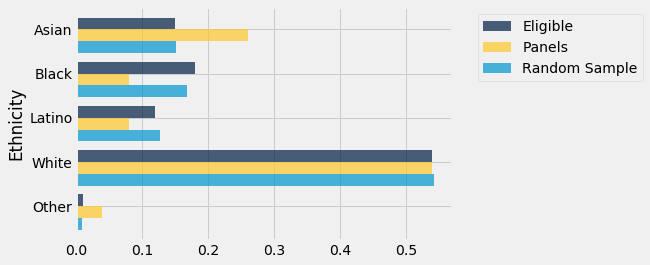

In [15]:
panels_and_sample.barh('Ethnicity')

The grey bars are a lot closer in size to the blue bars than the gold bars are. The random sample resembles the eligible population, but the panels don't.

We can quantify this observation by calculating the total variation distance between the distribution of the eligible population and the random sample. 

In [16]:
table_tvd(panels_and_sample, 'Eligible', 'Random Sample')

0.011748107364074285

Comparing this to the distance of 0.14 for the panel puts a numerical value on what we saw in the bar chart. The TVD between the eligible population and the panels was 0.14, but the TVD between the eligible population and the random sample is much smaller.

Of course, the distance between the distributions of the random sample and the eligible jurors depends on the sample. Sampling again might give a different result.

### By How Much Do Random Samples Differ from the Population?

The total variation distance between the distributions of the random sample and the eligible jurors is the statistic that we are using to measure the distance between the two distributions. By repeating the process of sampling, we can see how much the statistic varies across different random samples. The code below computes the empirical distribution of the statistic based on a large number of replications of the sampling process.

In [17]:
# Compute empirical distribution of TVDs

panel_size = 1453
repetitions = 5000

tvds = make_array()

for i in np.arange(repetitions):
    
    new_sample = proportions_from_distribution(jury, 'Eligible', panel_size)
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random Sample'))

results = Table().with_column('TVD', tvds)
results

TVD
0.0241913
0.0185134
0.00539573
0.00753613
0.0147488
0.0206332
0.0189745
0.0167309
0.0226635
0.00924295


Each row of the column above contains the total variation distance between a random sample of size 1453 (the size of the panels) and the population of eligible jurors.

The histogram of this column shows that drawing 1453 jurors at random from the pool of eligible candidates results in a distribution that rarely deviates from the eligible jurors' race distribution by more than 0.05.

Dragging the slider shows the histogram being built one sample at a time. Remember that each value added to the histogram is a single TVD value calculated by taking a sample at random from the population.

In [30]:
def hist_n_samples(tbl, n, bins=None):
    '''Draws histogram of first n rows of first column in tbl.'''
    tbl.take(np.arange(n)).hist(bins=bins)
    plt.ylim(0, 53)
    plt.show()

In [31]:
_ = interact(hist_n_samples, tbl=fixed(results),
             n=widgets.IntSlider(min=1, max=repetitions, value=1, continuous_update=False),
             bins=fixed(np.arange(0, 0.2, 0.005)))

A Jupyter Widget

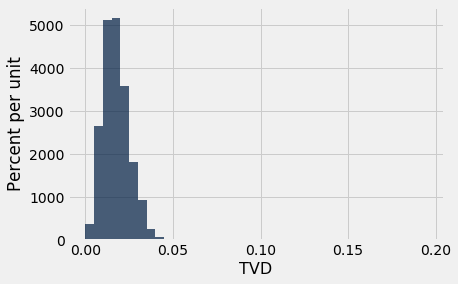

In [18]:
# Here's the complete histogram of the null distribution
results.hist(bins=np.arange(0, 0.2, 0.005))

### How do the panels compare with random samples?

The panels in the study, however, were not quite so similar to the eligible population. The total variation distance between the panels and the population was 0.14, which is far out in the tail of the histogram above. It does not look like a typical distance between a random sample and the eligible population.

So our analysis supports the ACLU's calculation that the panels were not representative of the distribution provided for the eligible jurors. As with most such analyses, however, it does not say *why* the distributions are different or what the difference might imply.

The ACLU report discusses several possible reasons for the discrepancies. For example, some minority groups were underrepresented on the records of voter registration and of the Department of Motor Vehicles, the two main sources from which jurors are selected. At the time of the study, the county did not have an effective process for following up on prospective jurors who had been called but had failed to appear. The ACLU listed several other reasons as well. Whatever the reasons, it seems clear that the composition of the jury panels was different from what we would have expected in a random sample from the distribution in the `Eligible` column.

### Questions about the Data ###
We have developed a powerful technique that helps decide whether one distribution looks like a random sample from another. But data science is about more than techniques. In particular, data science always involves a thoughtful examination of how the data were gathered.

**Eligible Jurors.** First, it is important to remember that not everyone is eligible to serve on a jury. On its [website](http://www.alameda.courts.ca.gov/pages.aspx/jury-duty-overview), the Superior Court of Alameda County says, "You may be called to serve if you are 18 years old, a U.S. citizen and a resident of the county or district where summoned. You must be able to understand English, and be physically and mentally capable of serving. In addition, you must not have served as any kind of juror in the past 12 months, nor have been convicted of a felony."

The Census doesn't maintain records of the populations in all these categories. Thus the ACLU had to obtain the demographics of eligible jurors in some other way. Here is their own description of the process they followed and some flaws that it might contain.

"For the purpose of determining the demographics of Alameda County’s jury eligible population, we used a declaration that was prepared for the Alameda County trial of People v. Stuart Alexander in 2002. In the declaration, Professor Weeks, a demographer at San Diego State University, estimated the jury eligible population for Alameda County, using the 2000 Census data. To arrive at this estimate, Professor Weeks took into account the number of people who are not eligible for jury services because they do not speak English, are not citizens, are under 18, or have a felony conviction. Thus, his estimate should be an accurate assessment of who is actually eligible for jury service in Alameda County, much more so than simply reviewing the Census report of the race and ethnicity of all people living in Alameda County. It should be noted, however, that the Census data on which Professor Weeks relied is now ten years old and the demographics of the county may have changed by two or three percent in some categories."

Thus the distribution of ethnicities of eligible jurors used in the analysis is itself an estimate and might be somewhat out of date.

**Panels.** In addition, panels aren't selected from the entire eligible population. The Superior Court of Alameda County says, "The objective of the court is to provide an accurate cross-section of the county's population. The names of jurors are selected at random from everyone who is a registered voter and/or has a driver's license or identification card issued by the Department of Motor Vehicles."

All of this raises complex questions about how to accurately estimate the ethnic composition of eligible jurors in Alameda County. 

It is not clear exactly how the 1453 panelists were classified into the different ethnic categories (the ACLU report says that "attorneys ... cooperated in collecting jury pool data"). There are serious social, cultural, and political factors that affect who gets classified or self-classifies into each ethnic category. We also don't know whether the definitions of those categories in the panels are the same as those used by Professor Weeks who in turn used Census categories in his estimation process. Thus there are also questions about the correspondence between the two distributions being compared.

Thus, while we have a clear conclusion about the data in our table – the panels do not look like a random sample from the distribution provided for eligible jurors – questions about the nature of the data prevent us from concluding anything broader.

### U.S. Supreme Court, 1965: Swain vs. Alabama ###

In the early 1960's, in Talladega County in Alabama, a black man called Robert Swain was convicted of raping a white woman and was sentenced to death. He appealed his sentence, citing among other factors the all-white jury. At the time, only men aged 21 or older were allowed to serve on juries in Talladega County. In the county, 26% of the eligible jurors were black, but there were only 8 black men among the 100 selected for the jury panel in Swain's trial. No black man was selected for the trial jury.

In 1965, the Supreme Court of the United States denied Swain's appeal. In its ruling, the Court wrote "... the overall percentage disparity has been small and reflects no studied attempt to include or exclude a specified number of Negroes."

Let's use the methods we have developed to examine the disparity between 8 out of 100 black men in the panel and the distribution of the eligible jurors.

In [35]:
swain_jury = Table().with_columns(
    'Ethnicity', make_array('Black', 'Other'),
    'Eligible', make_array(0.26, 0.74),
    'Panel', make_array(0.08, 0.92)
)

swain_jury

Ethnicity,Eligible,Panel
Black,0.26,0.08
Other,0.74,0.92


In [36]:
table_tvd(swain_jury, 'Eligible', 'Panel')

0.18000000000000002

The total variation distance between the two distributions is 0.18. How does this compare with the TVD between the distributions of the eligible population and a random sample? 

To answer this, we can simulate the TVD computed from a random sample.

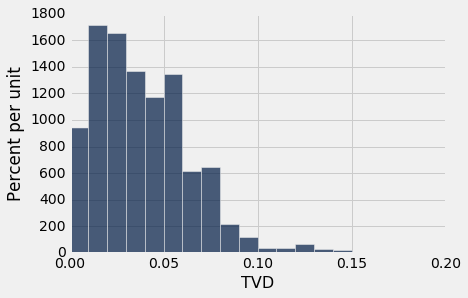

In [38]:
# Compute empirical distribution of TVDs

panel_size = 100
repetitions = 5000

tvds = make_array()

for i in np.arange(repetitions):
    
    new_sample = proportions_from_distribution(swain_jury, 'Eligible', panel_size)
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random Sample'))

results = Table().with_column('TVD', tvds)
results.hist(bins = np.arange(0, 0.2, 0.01))

The random samples typically have a much smaller TVD than the value of 0.18 that we got for the panel and the eligible jurors. 

In this analysis, the data are not clouded by questions as in our previous analysis – the total numbers of people involved were relatively small, and the counting was done carefully for the Supreme Court case. 

Thus our analysis has a clear conclusion, which is that the panel was not representative of the population. It is hard to accept the Supreme Court's judgment that "the overall percentage disparity has been small."